In [10]:
from tweepy import API 
from tweepy import Cursor
from tweepy import OAuthHandler
from tweepy import Stream
import config 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.types import LongType, StringType, TimestampType
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col

# # # # TWITTER CLIENT # # # #
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client

    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets

    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list

    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets


# # # # TWITTER AUTHENTICATER # # # #
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = OAuthHandler(config.API_Key, config.API_Key_Secret)
        auth.set_access_token(config.Access_Token, config.Access_Token_Secret)
        return auth


# # # # TWITTER STREAM LISTENER # # # #


In [11]:

# # # # TWITTER STREAM LISTENER # # # #
class TwitterListener(Stream):
    """
    This is a basic listener that just prints received tweets to stdout.
    """
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on_data %s" % str(e))
        return True
          
    def on_error(self, status):
        if status == 420:
            # Returning False on_data method in case rate limit occurs.
            return False
        print(status)

In [12]:
class TweetAnalyzer():
    """
    Functionality for analyzing and categorizing content from tweets.
    """


    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame([tweet.text for tweet in tweets])

        
        return df

In [13]:


spark = SparkSession.builder.appName("tweet").config("spark.drive.meory","20g").getOrCreate()

spark


In [14]:

if __name__ == '__main__':
    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()

    api = twitter_client.get_twitter_client_api()

    tweets = api.user_timeline(screen_name="realDonaldTrump",count=1000)

    # Create a list to store the tweet texts
    tweet_texts = []

    # Extract tweet texts from the API response
    for tweet in tweets:
        tweet_texts.append(tweet.text)

    # Create a DataFrame from the tweet texts
    df = pd.DataFrame({'tweets': tweet_texts})

    # Print the first 100 rows of the DataFrame
    print(df.head(100))

    # Save the DataFrame as a CSV file
    df.to_csv('twitter_data.csv', index=False)


                                               tweets
0   To all of those who have asked, I will not be ...
1   The 75,000,000 great American Patriots who vot...
2                             https://t.co/csX07ZVWGe
3   I am asking for everyone at the U.S. Capitol t...
4   Please support our Capitol Police and Law Enfo...
..                                                ...
95  RT @alaynatreene: NEW: A growing number of Rep...
96  RT @SenatorLankford: Today, I am joining a gro...
97                            https://t.co/nslWcFwkCj
98       RT @realDonaldTrump: https://t.co/t6nWHJjJAN
99  RT @HawleyMO: Glad to see more Senators joinin...

[100 rows x 1 columns]


In [15]:
data = spark.read.csv('twitter_data.csv', header=True, inferSchema=True)
# Display the schema of the DataFrame
data.printSchema()

# Display the first few rows of the DataFrame
data.show(5)

# Check the summary statistics of the dataset
data.describe().show()

# Check the number of rows in the dataset
print("Total number of rows:", data.count())
print(type(data))



root
 |-- tweets: string (nullable = true)

+--------------------+
|              tweets|
+--------------------+
|To all of those w...|
|The 75,000,000 gr...|
|https://t.co/csX0...|
|I am asking for e...|
|Please support ou...|
+--------------------+
only showing top 5 rows

+-------+--------------------+
|summary|              tweets|
+-------+--------------------+
|  count|                 233|
|   mean|                null|
| stddev|                null|
|    min|"New Lott study e...|
|    max|🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸|
+-------+--------------------+

Total number of rows: 233
<class 'pyspark.sql.dataframe.DataFrame'>


In [16]:
# Drop columns that are not relevant for analysis
columns_to_drop = ['column1', 'column2']
data = data.drop(*columns_to_drop)

# Remove duplicate rows
data = data.dropDuplicates()


In [17]:
data.describe().show()


+-------+--------------------+
|summary|              tweets|
+-------+--------------------+
|  count|                 232|
|   mean|                null|
| stddev|                null|
|    min|"New Lott study e...|
|    max|🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸|
+-------+--------------------+



In [18]:

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Extract desired features from tweets
tweet_info = [(tweet.id, len(tweet.text), tweet.created_at, tweet.source, tweet.favorite_count, tweet.retweet_count,tweet.text) for tweet in tweets]

# Create DataFrame from the tweet information
df = spark.createDataFrame(tweet_info, schema=['id', 'len', 'date', 'source', 'likes', 'retweets','text'])

# Show the DataFrame
df.show(1000, truncate=False)


+-------------------+---+-------------------+--------------------+------+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id                 |len|date               |source              |likes |retweets|text                                                                                                                                                          |
+-------------------+---+-------------------+--------------------+------+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1347569870578266115|88 |2021-01-08 16:44:28|Twitter for iPhone  |638653|78873   |To all of those who have asked, I will not be going to the Inauguration on January 20th.                                                                      |
|1347555316863553542|140|2021-01

In [19]:
data.describe().show()

+-------+--------------------+
|summary|              tweets|
+-------+--------------------+
|  count|                 232|
|   mean|                null|
| stddev|                null|
|    min|"New Lott study e...|
|    max|🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸|
+-------+--------------------+



In [20]:
# Identify the top 10 users by the number of tweets
user_counts = data.groupBy('user').count().orderBy('count', ascending=False).limit(10)
user_counts.show()


+--------------+-----+
|current_user()|count|
+--------------+-----+
|   iheb akermi|  232|
+--------------+-----+



In [21]:


# Define the sentiment analysis function
def analyze_sentiment(text):
    positive_words = ["Love","Joy","is coming", "Happy", "Bliss", "Gratitude", "Excitement","smart","hardworker" "Hope", "Passion", "Success", "Achievement", "Abundance", "Serenity", "Generosity", "Kindness", "Compassion", "Laughter", "Friendship", "Empathy", "Confidence", "Courage", "Inspiration", "Motivation", "Optimism", "Contentment", "Appreciation", "Respect", "Unity", "Harmony", "Growth", "Vitality"]
    negative_words = ["Hate", "Sadness", "Anger", "Grief", "Disappointment", "Failure", "Loneliness", "Fear", "Anxiety", "Stress", "Conflict", "Misery", "Pain", "Sorrow", "Regret", "Frustration", "Jealousy", "Envy", "Insecurity", "Doubt", "Despair", "Shame", "Guilt", "Resentment", "Bitterness", "Hostility", "Neglect", "Rejection", "Defeat", "Betrayal"]

    sentiment_label = 0
    l=[]
    for word in text.split():
        l.append(word)
        if word in positive_words:
            sentiment_label = 1
            break
        elif word in negative_words:
            sentiment_label = -1
            break

    return sentiment_label

# Register the sentiment analysis function as a UDF
sentiment_udf = udf(analyze_sentiment, IntegerType())

# Apply the UDF to create a new column with numeric sentiment labels
df = df.withColumn("sentiment", sentiment_udf(col("text")))


In [22]:
df.show(100)

+-------------------+---+-------------------+--------------------+------+--------+--------------------+---------+
|                 id|len|               date|              source| likes|retweets|                text|sentiment|
+-------------------+---+-------------------+--------------------+------+--------+--------------------+---------+
|1347569870578266115| 88|2021-01-08 16:44:28|  Twitter for iPhone|638653|   78873|To all of those w...|        0|
|1347555316863553542|140|2021-01-08 15:46:38|  Twitter for iPhone|535157|   89757|The 75,000,000 gr...|        0|
|1347334804052844550| 23|2021-01-08 01:10:24|Twitter Media Studio|649563|  129916|https://t.co/csX0...|        0|
|1346912780700577792|144|2021-01-06 21:13:26|  Twitter for iPhone|706066|  138891|I am asking for e...|        0|
|1346904110969315332|112|2021-01-06 20:38:58|  Twitter for iPhone|539235|   89916|Please support ou...|        0|
|1346891760174329859| 23|2021-01-06 19:49:54|  Twitter for iPhone|215700|   42978|https:

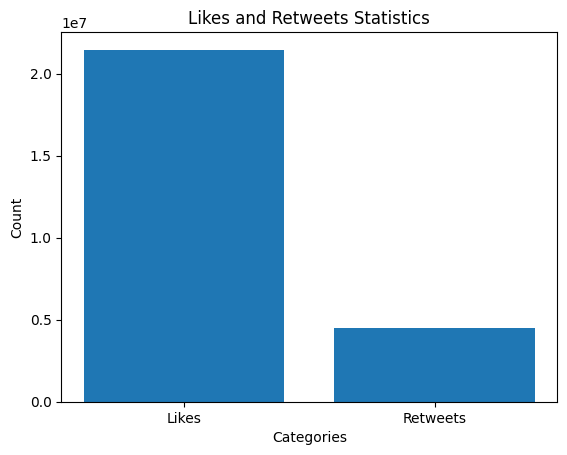

In [23]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt



# Sélectionner les colonnes pertinentes (likes et retweets)
data = df.select('likes', 'retweets')

# Agréger les statistiques en utilisant Spark SQL
stats = df.agg(F.sum('likes').alias('total_likes'), F.sum('retweets').alias('total_retweets')).first()


# Extraire les valeurs des statistiques
total_likes = stats['total_likes']
total_retweets = stats['total_retweets']

# Tracer le graphique à barres
categories = ['Likes', 'Retweets']
values = [total_likes, total_retweets]

plt.bar(categories, values)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Likes and Retweets Statistics')
plt.show()


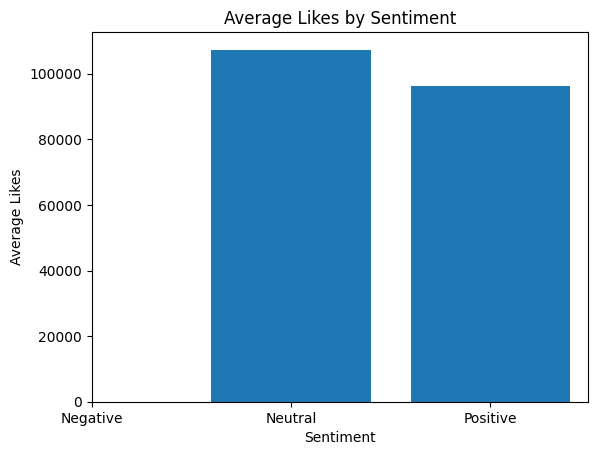

In [25]:
import matplotlib.pyplot as plt

# Group the data by sentiment and calculate the average likes
sentiment_likes = df.groupby('sentiment').agg({'likes': 'mean'}).toPandas()

# Plot the data
plt.bar(sentiment_likes['sentiment'], sentiment_likes['avg(likes)'])
plt.xlabel('Sentiment')
plt.ylabel('Average Likes')
plt.title('Average Likes by Sentiment')
plt.xticks([-1, 0, 1], ['Negative', 'Neutral', 'Positive'])
plt.show()


In [ ]:
print(data)

DataFrame[likes: bigint, retweets: bigint]
